In [1]:
import pandas as pd

# Text Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Tuning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#Evaluation Libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#Supress 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Overview

We used a 80-20 train-test split, retaining 20% of the dataset to estimate model performance and using the remaining 80% to select a model. Several candidate models were compared using grid-search cross validation.  This process suggested the use of an XGBoost model.  Using this model, we refined our selected hyperparameters using the hyperopt package to 

## Data Ingest and Setup

In [2]:
dataframe = pd.read_csv('training_set_v2.csv')
#Drop Extrinsic Laws
dataframe['year'] = dataframe['id'].astype(str).str[:4].astype('int64')
dataframe = pd.get_dummies(dataframe, columns=['type'])
categorical_cols =  dataframe.select_dtypes(include=['uint8'])
features = dataframe.loc[:,['year','section_text']].copy()
features = pd.concat([features, categorical_cols], axis=1)
target = dataframe['jim_crow']

20% of the data is set aside for assessment and the remaining 80% is used to compare models.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=25)

## Preprocessing and Analysis Setup

The analysis is packaged into a scikit-learn Pipeline to ensure that all steps can be easily applied within cross-validation folds.  Some feautres (e.g. tf-idf) could allow data from validation (or even the test set) to leak through if performed earlier.

In [4]:
stopword = stopwords.words('english')
# regular expression to identify non-ascii characters
non_ascii_regex = r'[^\x00-\x7F]+'
def tokenize(text):     
    text = re.sub(non_ascii_regex, ' ', text)  
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]
    return clean_tokens

class LengthExtractor(BaseEstimator, TransformerMixin):   
    def compute_length(self, text):
        sentence_list = word_tokenize(text)
        return len(sentence_list) 
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)


class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def transform(self, X, **transform_params):
        out = X[self.columns].copy()
        return out
    def fit(self, X, y=None, **fit_params):
        return self

In [5]:
pipeline = Pipeline([
        ('features', FeatureUnion([
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 1000)),
                ('tfidf', TfidfTransformer()),
            ])),
            ('text_len', Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ])),
            ('metadata', SelectColumnsTransformer())
        ])),
        # set default estimator RandomForestClassifier 
        ('dlf', RandomForestClassifier())
])

## Cross Validation
Candidate models' performance was compared using grid search cross validation, measured using F1 scores.  Parameters passed to the param_grid below change the behavior of the underlying estimators and the preprocessing defined in the Pipeline above.

In [6]:
param_grid = [
    {#####Random Forest#####
    'features__text_pipeline__vect__min_df': [2, 10],
    'features__text_pipeline__vect__max_df': [0.5,0.9],
    'features__text_pipeline__vect__lowercase': [True,False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__text_len': [Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ]), 'passthrough'],
    'features__metadata__columns': [[],['type_private laws', 'type_public laws',
                                        'type_public local laws','type_session laws','year']],
    'dlf' : [RandomForestClassifier()],
    'dlf__n_estimators' : [50, 100, 500, 1000],
    'dlf__max_depth' : [100, 200, 300],
    'dlf__class_weight' : [None, "balanced"]
    },
    {#####Multinomial Naive Bayes#####
    'features__text_pipeline__vect__min_df': [2,10],
    'features__text_pipeline__vect__max_df': [0.5,0.9],
    'features__text_pipeline__vect__lowercase': [True,False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__text_len': [Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ]), 'passthrough'],
    'features__metadata__columns': [[],['type_private laws', 'type_public laws',
                                        'type_public local laws','type_session laws','year']],
    'dlf' : [MultinomialNB()],
    'dlf__alpha':  [1, 0.01, 0.0001]
    },
    {#####Stochastic Gradient Descent Classifier (including SVM)#####
    'features__text_pipeline__vect__min_df': [2,10],
    'features__text_pipeline__vect__max_df': [0.5,0.9],
    'features__text_pipeline__vect__lowercase': [True,False],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2)],
    'features__text_pipeline__tfidf': [TfidfTransformer(), 'passthrough'],
    'features__text_len': [Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ]), 'passthrough'],
    'features__metadata__columns': [[],['type_private laws', 'type_public laws',
                                        'type_public local laws','type_session laws','year']],
    'dlf' : [SGDClassifier()],
    'dlf__loss':  ["hinge", "modified_huber","log"],
    'dlf__penalty': ['l2','elasticnet'],
    'dlf__learning_rate': ['optimal'],
    'dlf__alpha':  [1, 0.01, 0.0001]
    },
    {#####XGBoost#####
    'features__text_pipeline__vect__min_df': [5,10],
    'features__text_pipeline__vect__max_df': [0.7,0.9],
    'features__text_pipeline__vect__lowercase': [True],
    'features__text_pipeline__vect__ngram_range': [(1,1),(1,2)],
    'features__text_pipeline__tfidf': ['passthrough'],
    'features__text_len': [Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ]), 'passthrough'],
    'features__metadata__columns': [['type_private laws', 'type_public laws',
                                        'type_public local laws','type_session laws','year']],
    'dlf' : [XGBClassifier()],
    'dlf__learning_rate': [0.2, 0.3, 0.4],
    'dlf__max_depth': [9, 12, 15],
    'dlf__min_child_weight': [1, 3],
    'dlf__gamma': [0.5, 1, 2],
    'dlf__colsample_bytree' : [0.5, 0.6],
    'dlf__scale_pos_weight' : [1,3],
    'dlf__tree_method' : ["hist"]
    }
]

The following loop summarizes the best performance by each model considered.  This search is time-intensive, so is disabled here.

In [7]:
# fit_dict = dict()
# for params in param_grid:
#     estimator = str(params["dlf"][0]).replace("()","")
#     fit_dict[estimator] = GridSearchCV(pipeline, param_grid=params, n_jobs = 32, cv=5, scoring='f1', verbose=1)
#     _ = fit_dict[estimator].fit(X_train, y_train)
#     print(estimator + " COMPLETE ########################")
#     print("Best Score: " + str(round(fit_dict[estimator].best_score_,4)))

The best fitting model was XGBoost (F1 Score: 0.9588).  We further refined this model using HyperOpt to better search the parameter space.

## Bayesian Hyperparameter search with HyperOpt



In [8]:
pipeline = Pipeline([

        ('features', FeatureUnion([

            # Extract features
            ('text_pipeline', Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 0.8)),
                ('tfidf', 'passthrough'),
            ])),
            ('text_len', Pipeline([
                ('get_text', SelectColumnsTransformer("section_text")),
                ('length', LengthExtractor())
            ])),
            ('metadata', SelectColumnsTransformer(['type_private laws', 'type_public laws',
                                        'type_public local laws','type_session laws','year']))
        ])),
        ('dlf',XGBClassifier(tree_method="hist"))
])

Using the same pipeline as the previous process, we'll set up an objective function and define the parameter space we want to search within.  Again, we use the F1 score as our performance measure.  The example below runs a few trials.  The project used 1000 evals instead of 5.

In [9]:
from hyperopt import hp, tpe, space_eval, Trials
from hyperopt.fmin import fmin

def objective(params):
    params['features__text_pipeline__vect__min_df'] = int(params['features__text_pipeline__vect__min_df'])
    params['dlf__max_depth'] = int(params['dlf__max_depth'])
    params['dlf__min_child_weight'] = int(params['dlf__min_child_weight'])
    params['dlf__scale_pos_weight'] = int(params['dlf__scale_pos_weight'])
    pipeline.set_params(**params)
    
    score = 1-cross_val_score(pipeline, X_train, y_train, scoring="f1", n_jobs=-1).mean()
    print("F1 {:.4f} params {}".format((1-score), params))
    return score

space = {
    'features__text_pipeline__vect__min_df': hp.quniform ('features__text_pipeline__vect__min_df',2,20,1),
    'features__text_pipeline__vect__lowercase': hp.choice('features__text_pipeline__vect__lowercase',[True,False]),
    'features__text_pipeline__vect__ngram_range': hp.choice('features__text_pipeline__vect__ngram_range',[(1,1),(1,2),(1,3),(1,4)]),
    'features__text_pipeline__vect__max_df': hp.uniform('features__text_pipeline__vect__max_df',0.6,0.8),
    'features__text_len':hp.choice('features__text_len',[Pipeline([
            ('get_text', SelectColumnsTransformer("section_text")),
            ('length', LengthExtractor())
        ])]),
    'dlf__max_depth': hp.quniform('dlf__max_depth', 2, 10, 1),
    'dlf__min_child_weight': hp.quniform('dlf__min_child_weight', 1, 5, 1),
    'dlf__colsample_bytree': hp.uniform('dlf__colsample_bytree', 0.3, 1.0),
    'dlf__learning_rate': hp.uniform('dlf__learning_rate', 0.05, 1),
    'dlf__scale_pos_weight': hp.quniform('dlf__scale_pos_weight',1,8,1),
    'dlf__gamma': hp.uniform('dlf__gamma',0,2)
    
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5, #actual fit was run with 1000 evals
           trials=trials)


F1 0.9377 params {'dlf__colsample_bytree': 0.6228792662262748, 'dlf__gamma': 0.589206708162038, 'dlf__learning_rate': 0.8216976728629352, 'dlf__max_depth': 3, 'dlf__min_child_weight': 3, 'dlf__scale_pos_weight': 4, 'features__text_len': Pipeline(steps=[('get_text', SelectColumnsTransformer(columns='section_text')),
                ('length', LengthExtractor())]), 'features__text_pipeline__vect__lowercase': True, 'features__text_pipeline__vect__max_df': 0.7516040448161234, 'features__text_pipeline__vect__min_df': 4, 'features__text_pipeline__vect__ngram_range': (1, 3)}
F1 0.9328 params {'dlf__colsample_bytree': 0.9498850608152181, 'dlf__gamma': 0.12603934587749754, 'dlf__learning_rate': 0.7645360138092586, 'dlf__max_depth': 9, 'dlf__min_child_weight': 1, 'dlf__scale_pos_weight': 2, 'features__text_len': Pipeline(steps=[('get_text', SelectColumnsTransformer(columns='section_text')),
                ('length', LengthExtractor())]), 'features__text_pipeline__vect__lowercase': False, 'featu

The example search above selected the following parameters:

In [10]:
space_eval(space, best)

{'dlf__colsample_bytree': 0.6806352025275062,
 'dlf__gamma': 1.4653103872599336,
 'dlf__learning_rate': 0.1338333089876192,
 'dlf__max_depth': 6.0,
 'dlf__min_child_weight': 2.0,
 'dlf__scale_pos_weight': 2.0,
 'features__text_len': Pipeline(steps=[('get_text', SelectColumnsTransformer(columns='section_text')),
                 ('length', LengthExtractor())]),
 'features__text_pipeline__vect__lowercase': True,
 'features__text_pipeline__vect__max_df': 0.6663072734163493,
 'features__text_pipeline__vect__min_df': 4.0,
 'features__text_pipeline__vect__ngram_range': (1, 2)}

The final results were based on the following parameters, selected in a larger search:

In [11]:
model_params = {'dlf__colsample_bytree': 0.38802577686511047,
 'dlf__gamma': 0.20211144034640516,
 'dlf__learning_rate': 0.13027378372211787,
 'dlf__max_depth': 4.0,
 'dlf__min_child_weight': 1.0,
 'dlf__scale_pos_weight': 3.0,
 'features__text_len': Pipeline(steps=[('get_text', SelectColumnsTransformer(columns='section_text')),
                 ('length', LengthExtractor())]),
 'features__text_pipeline__vect__lowercase': True,
 'features__text_pipeline__vect__max_df': 0.7538214490256765,
 'features__text_pipeline__vect__min_df': 4.0,
 'features__text_pipeline__vect__ngram_range': (1, 4)}

model_params['features__text_pipeline__vect__min_df'] = int(model_params['features__text_pipeline__vect__min_df'])
model_params['dlf__max_depth'] = int(model_params['dlf__max_depth'])
model_params['dlf__min_child_weight'] = int(model_params['dlf__min_child_weight'])
model_params['dlf__scale_pos_weight'] = int(model_params['dlf__scale_pos_weight'])

best_model = pipeline
best_model.set_params(**model_params)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('get_text',
                                                                  SelectColumnsTransformer(columns='section_text')),
                                                                 ('vect',
                                                                  CountVectorizer(decode_error='ignore',
                                                                                  max_df=0.7538214490256765,
                                                                                  min_df=4,
                                                                                  ngram_range=(1,
                                                                                               4))),
                                                                 ('tfidf',
                                                        

## Test Set Performance

With a model selected, we use the 20% test set to measure the performance of the selected model.

[09:52:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Text(0.5, 1.0, 'Overall')]

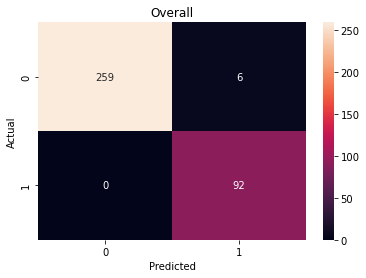

In [12]:
y_pred = best_model.fit(X_train,y_train).predict(X_test)

# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')
ax.set(title="Overall")

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       265
           1       0.94      1.00      0.97        92

    accuracy                           0.98       357
   macro avg       0.97      0.99      0.98       357
weighted avg       0.98      0.98      0.98       357



The fit model was 98% accurate on the test set.  This provides an estimate of how accurate our model would be on new data.  With this estimate, we can refit the model using the entire training set below.  This refit model was used to apply classifications to the entire corpus.

In [14]:
refit = best_model.fit(dataframe,dataframe.jim_crow)

[09:52:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
